# Test code for computing registration metrics (reproducibilty) 

1. Check xcorr_vol between two outputs of the two preproc runs 
2. Check registration params
    - xfminvert stx2_052_S_1251_20070309_t1.xfm test.xfm
    - xfm2param test.xfm


**Expected use case:** 
    Run this script after preprocessing is complete to provide info on each subject

In [125]:
import pandas as pd
import numpy as np
import sys
import os
import re
import subprocess
import matplotlib.pyplot as plt
import seaborn as sns
sys.path.append('../')
from lib.preproc_checks import *

# Data paths

In [29]:
proj_dir = '/Users/nikhil/projects/MR_preproc_dash/'
data_dir = proj_dir + 'data/'
script_dir = proj_dir + 'scripts/'
preproc_pipeline_dir = '/Users/nikhil/code/git_repos/nist_mni_pipelines/'

if preproc_pipeline_dir not in sys.path:
    sys.path.append(preproc_pipeline_dir)

# Calling minc from python
**Using subprocess (a bit hacky but easier than pyminc interface!)**

In [93]:
# Single timepoint 
vol1 = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.mnc'
vol2 = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.mnc'
xfm1 = data_dir + '052_S_4807/20121019/stx/stx_052_S_4807_20121019_t1.xfm'

xcorr = get_xcorr_vol(vol1,vol2)
reg_param = get_reg_params(xfm1)

print(xcorr)
print(reg_param)

1.0
                   x        y        z
center             0        0        0
translation   2.0631  43.5027  7.50818
rotation     2.59585  0.26141 -0.98333
scale        0.94557  0.95997  0.87936
shear        0.00055 -0.00056  0.00873


In [152]:
# Get reg_params for all timepoints
subjects = ['052_S_4807','052_S_4807','052_S_4807','052_S_4807','052_S_4807']
timepoints = ['20121019', '20130215', '20130813', '20140807', '20150804']
reg_cols = ['x_center', 'y_center', 'z_center', 'x_rotation', 'y_rotation',
       'z_rotation', 'x_scale', 'y_scale', 'z_scale', 'x_shear', 'y_shear',
       'z_shear', 'x_translation', 'y_translation', 'z_translation']

reg_param_list = []
reg_param_flat = pd.DataFrame()
for s, subject_idx in enumerate(subjects):
    for t,tp in enumerate(timepoints):
        xfm = data_dir + '{}/{}/stx/stx_{}_{}_t1.xfm'.format(subject_idx,tp,subject_idx,tp)
        reg_param = (1+s) * (1+t) * get_reg_params(xfm).apply(pd.to_numeric)
        v = reg_param.unstack().to_frame().sort_index(level=1).T
        v.columns = v.columns.map('_'.join)
        
        v['subject_idx'] = subject_idx
        v['tp'] = tp
        reg_param_flat = reg_param_flat.append(v)
        reg_param_list.append(reg_param)
    
print(pd.concat(reg_param_list).groupby(level=0).mean())
print(pd.concat(reg_param_list).groupby(level=0).std())

                    x          y         z
center        0.00000    0.00000   0.00000
rotation     23.36265    2.35269  -8.84997
scale         8.51013    8.63973   7.91424
shear         0.00495   -0.00504   0.07857
translation  18.56790  391.52412  67.57362
                     x           y          z
center        0.000000    0.000000   0.000000
rotation     16.756140    1.687394   6.347368
scale         6.103628    6.196580   5.676244
shear         0.003550    0.003615   0.056352
translation  13.317253  280.808592  48.465094


In [92]:
def get_reg_diff(df1,df2):
    return (df1-df2).abs()

def get_xcorr_vol(vol1,vol2):
    minc_xcorr_cmd = script_dir + 'run_xcorr_cmd.sh' + ' ' + vol1 + ' ' + vol2
    xcorr = 0
    try:
        xcorr = float(subprocess.check_output(minc_xcorr_cmd, shell=True))
    except:
        print('Could not run minc command. Check minc script / command: \n{}\n'.format(minc_xcorr_cmd))
        
    return xcorr

def get_reg_params(xfm):
    minc_reg_param_cmd = script_dir + 'run_reg_param_cmd.sh' + ' ' + xfm1
    reg_df = pd.DataFrame(index=['center','translation','rotation','scale','shear'],columns=['x','y','z'])
    string_check = False
    origin_check = False
    
    try: 
        reg_param_str = str(subprocess.check_output(minc_reg_param_cmd, shell=True),'utf-8')
        #print(reg_param_str)
        reg_param_split = str.split(reg_param_str,' ')        

        # Check if output string is what you expect
        string_check = ((reg_param_split[3]=='-center') & (reg_param_split[7]=='-translation') & 
                        (reg_param_split[11]=='-rotation') & (reg_param_split[15]=='-scale') & 
                        (reg_param_split[19]=='-shear'))

        # Check if origin = [0,0,0]
        if string_check:
            origin_check = (np.array(reg_param_split[4:7]).astype(float) == [0,0,0]).all()

            if origin_check:
                reg_df.loc['center'] = np.array(reg_param_split[4:7]).astype(float)
                reg_df.loc['translation'] = np.array(reg_param_split[8:11]).astype(float)
                reg_df.loc['rotation'] = np.array(reg_param_split[12:15]).astype(float)
                reg_df.loc['scale'] = np.array(reg_param_split[16:19]).astype(float)
                reg_df.loc['shear'] = np.array(reg_param_split[20:23]).astype(float)
            else:
                print('Origin is not at [0,0,0]. Check input image space.')
        else: 
            print('minc command output string doesnot match expected output from xfm2param')
    except:
        print('Could not run minc command. Check minc script / command: \n{}\n'.format(minc_reg_param_cmd))

    return reg_df


NameError: name 'FormatStrFormatter' is not defined

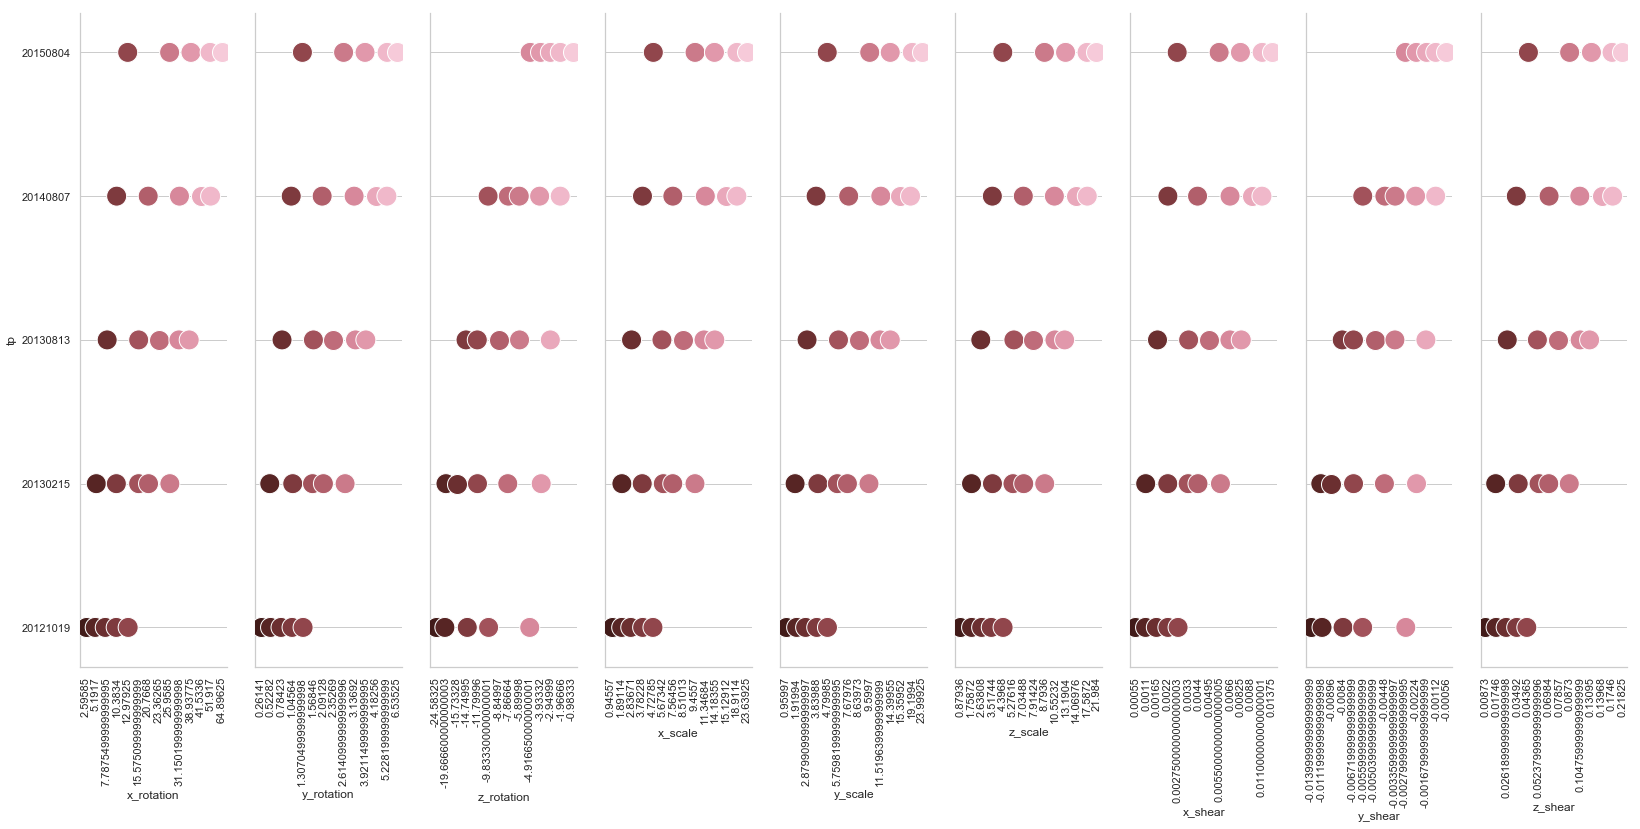

In [159]:
# Make the PairGrid
sns.set(style="whitegrid")
g = sns.PairGrid(reg_param_flat,
                 x_vars=reg_param_flat.columns[3:-5], y_vars=["tp"],
                 height=10, aspect=.25)
# Draw a dot plot using the stripplot function
g.map(sns.stripplot, size=20, orient="v",
      palette="ch:s=1,r=-.1,h=1_r", linewidth=1, edgecolor="w")

# Use the same x axis limits on all columns and add better labels
#g.set(xlim=(0, 25), xlabel="Crashes", ylabel="")
[plt.setp(g.get_xticklabels(), rotation=90) for g in g.axes.flat]
[g.xaxis.set_major_formatter(FormatStrFormatter('%.2f')) for g in g.axes.flat]


# Make the grid horizontal instead of vertical
for ax in g.axes.flat:
    ax.xaxis.grid(True)
    ax.yaxis.grid(True)

sns.despine(left=True, bottom=True)